In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
from IPython.display import display  # to display variables in a "nice" way
from mpl_toolkits.mplot3d import Axes3D
# pd.options.display.max_rows = 9999
pd.options.display.max_columns = 200

Setting the Random State:

In [ ]:
IDs =  [312920,312919,313385]
rs = np.min(IDs)
np.random.seed(rs)

Exercise 1 (Loading and Preparing the Data):

(a)

In [ ]:
# PATH TO THE cla4lsp22_bikez_curated.csv FILE
bikez_path = 'cla4lsp22_bikez_curated.csv'

# LOADING THE DATASET AS DATAFRAME then store in the variable df_tot
df_tot = pd.read_csv(bikez_path)

# DISPLAY OF THE DATAFRAME
# display(df_tot)

##### b) Generate x as a random number: 0, 1, or 2. workdf is the dftot containing only data corresponding to years with reminder r resulted by modulus 3

In [ ]:
x = int(np.random.uniform(0,3))
workdf = df_tot[df_tot['Year'] % 3 == x]
display(workdf)

##### c) Remove randomly from workdf two columns among the features: Front/Rear breaks, Front/Rear tire, Front/Rear suspension.

In [ ]:
temp_features = ['Front brakes', 'Rear brakes','Front tire', 'Rear tire','Front suspension', 'Rear suspension']

feat1,feat2 = np.random.choice(temp_features, 2, replace=False)
workdf = workdf.drop(columns=[feat1,feat2])

Denote:
labels: the columns Brand, Model, Year, Category, Rating;
features: all the other ones

In [ ]:
labels = workdf.columns[:5].tolist()
features = workdf.columns[5:].tolist()


d) Clean the dataset workdf from missing values in the feature columns (if needed).

##### Show percentage of missing values for each column of workdf

In [ ]:
# compute the percentage of NaN values for each column
na_percentage = workdf.isna().mean() * 100
display(na_percentage)

# filter the na_percentage series to only include columns with a percentage of NaN values > 0
na_percentage_filtered = na_percentage[na_percentage > 0]

# subtract the labels list from the list of columns with NaN values > 0
na_features = na_percentage_filtered.index.difference(labels).tolist()

Remove Nan values from 'Displacement (ccm)' since NaN values are sparse

In [ ]:
workdf.dropna(subset=['Displacement (ccm)'], inplace=True)


Fill Nan values from other columns by mean

In [ ]:
for col in na_features:
    workdf[col] = workdf[col].fillna(workdf[col].mean())

Exercise 2 (Encoding of Categorical Data):

In [ ]:
# select only the string columns in workdf that are in the features list
string_cols = workdf.select_dtypes(include=['object']).columns.intersection(features)

# apply one-hot encoding to the selected string columns
for col in string_cols:
    encoded_cols = workdf[col].str.get_dummies(sep='.').add_prefix(col + '_')
    workdf = pd.concat([workdf, encoded_cols], axis=1)

    # drop the original string column
    workdf.drop(col, axis=1, inplace=True)

# create a new DataFrame without the labels (only features)
Xworkdf = workdf.drop(columns=labels)

# print the updated DataFrame
display(Xworkdf)

#### Exercise 3 (Preprocessing and PCA): Preprocess the data, before applying the PCA

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
Xworkdf_std = pd.DataFrame(scaler.fit_transform(Xworkdf), columns=Xworkdf.columns)


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the data
Xworkdf_mm = pd.DataFrame(scaler.fit_transform(Xworkdf), columns=Xworkdf.columns)


To compare the variances of the original dataset Xworkdf with the variances of the datasets Xworkdf_std and Xworkdf_mm, we can calculate the variances of the non-categorical features in all three datasets.

Assuming that Xworkdf contains both categorical and non-categorical features, we can select only the non-categorical features as follows:

In [ ]:
noncat_features = Xworkdf.select_dtypes(exclude='object').columns

Then, we can calculate the variances of the non-categorical features in all three datasets:

In [ ]:
# Calculate variances of non-categorical features in Xworkdf
variances_original = Xworkdf[noncat_features].var()

# Calculate variances of non-categorical features in Xworkdf_std
variances_standardized = Xworkdf_std[noncat_features].var()

# Calculate variances of non-categorical features in Xworkdf_mm
variances_minmax = Xworkdf_mm[noncat_features].var()


Now we can compare the variances of the non-categorical features in the three dataframes. We can plot the variances using a bar plot:

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Display only the initial 20 characteristics for the sake of legibility as the features are extensive and displaying all of them would be unsuitable.
plt.bar(variances_original[:20].index, variances_original[:20], label='Original')

plt.xticks(rotation=90)
plt.title('Variances of the original data')
plt.ylabel('Variance')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Display only the initial 20 characteristics for the sake of legibility as the features are extensive and displaying all of them would be unsuitable.
plt.bar(variances_standardized[:20].index, variances_standardized[:20], label='Standardized')
plt.bar(variances_minmax[:20].index, variances_minmax[:20], label='Min-Max Scaled')
plt.xticks(rotation=90)
plt.title('Comparison of Variances')
plt.ylabel('Variance')
plt.legend()
plt.show()

This will produce two plot with three bars, one for each dataset, with the height of each bar representing the variance of the corresponding non-categorical feature.

From the plots, we can observe that the variances of the non-categorical features are different in the three datasets. Specifically, the variances of the standardized dataset Xworkdf_std are all equal to 1, as expected since this is a property of standardized data. On the other hand, the variances of the min-max scaled dataset Xworkdf_mm are all between 0 and 1, since this is the range specified by the MinMaxScaler. The variances of the original dataset Xworkdf are not normalized, and can be much larger than 1.

Based on this analysis, we can infer that scaling the non-categorical features using either a StandardScaler or a MinMaxScaler can help to ensure that these features are on the same scale and have comparable variances. This can be particularly important for certain machine learning algorithms, such as those that rely on distance-based calculations or regularization, where features with large variances can have a disproportionate impact on the algorithm's performance. However, the choice of scaler may depend on the specific requirements of the problem at hand, and in some cases it may be appropriate to use a different scaler or no scaler at all.

##### Here we use the PCA class from the sklearn.decomposition module to fit a PCA model to each of the three DataFrames, with n_components='mle' to retain all components. We then calculate the cumulative explained variance using the explained_variance_ratio_ attribute of the PCA object, and store the results in three arrays cumulative_variances_original, cumulative_variances_standardized, and cumulative_variances_minmax.

In [ ]:
from sklearn.decomposition import PCA

# Create a PCA object with all components
pca = PCA(n_components='mle')

# Fit the PCA model to the original data
pca.fit(Xworkdf)

# Calculate cumulative explained variance
cumulative_variances_original = np.cumsum(pca.explained_variance_ratio_)

# Fit the PCA model to the standardized data
pca.fit(Xworkdf_std)

# Calculate cumulative explained variance
cumulative_variances_standardized = np.cumsum(pca.explained_variance_ratio_)

# Fit the PCA model to the min-max scaled data
pca.fit(Xworkdf_mm)

# Calculate cumulative explained variance
cumulative_variances_minmax = np.cumsum(pca.explained_variance_ratio_)


In [ ]:
plt.plot(cumulative_variances_original, label='Original')
plt.plot(cumulative_variances_standardized, label='Standardized')
plt.plot(cumulative_variances_minmax, label='Min-Max Scaled')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of Components')
plt.legend()
plt.show()

This will produce a plot with three lines, one for each DataFrame, with the x-axis representing the number of components and the y-axis representing the cumulative explained variance.

The original dataset, Xworkdf, has a constant cumulative explained variance of 1, which means that all of the variance in the data is explained by the full set of features. This is expected, as the original dataset has not been transformed or scaled in any way.

The standardized dataset, Xworkdf_std, has a slower increase in cumulative explained variance compared to the min-max scaled dataset, Xworkdf_mm, but still reaches a cumulative variance of 0.9 after approximately 85 principal components and then it reached a cumulative variance of 1 after 110 components. This indicates that standardizing the dataset has reduced the impact of features with large variances, but there are still a large number of principal components required to explain the majority of the variance in the data.

In contrast, the min-max scaled dataset, Xworkdf_mm, has a much faster increase in cumulative explained variance and reaches a cumulative variance of 0.9 after only 25 principal components and then it reached 1 for the 65 components. This suggests that scaling the dataset to a specific range has had a significant impact on reducing the impact of features with large variances, and the majority of the variance in the data can be explained by a smaller number of principal components.

In [ ]:
# PCA on Xworkdf_std
pca_std = PCA().fit(Xworkdf_std)
# cumulative sum of explained variance
cum_var_std = np.cumsum(pca_std.explained_variance_ratio_)
# minimum number of PCs to explain 35% of variance
min_pc_std = np.argmax(cum_var_std >= 0.35) + 1
# number of PCs to select
num_pc_std = min(min_pc_std, 5)
# fit PCA with selected number of PCs
pca_std = PCA(n_components=num_pc_std).fit(Xworkdf_std)

In [ ]:
# PCA on Xworkdf_mm
pca_mm = PCA().fit(Xworkdf_mm)
# cumulative sum of explained variance
cum_var_mm = np.cumsum(pca_mm.explained_variance_ratio_)
# minimum number of PCs to explain 35% of variance
min_pc_mm = np.argmax(cum_var_mm >= 0.35) + 1
# number of PCs to select
num_pc_mm = min(min_pc_mm, 5)
# fit PCA with selected number of PCs
pca_mm = PCA(n_components=num_pc_mm).fit(Xworkdf_mm)

In [ ]:
# plot barplots of percentage of explained variance
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].bar(range(1, num_pc_std+1), pca_std.explained_variance_ratio_)
axs[0].set_title('Xworkdf_std')
axs[0].set_xlabel('PC')
axs[0].set_ylabel('Explained Variance Ratio')
axs[1].bar(range(1, num_pc_mm+1), pca_mm.explained_variance_ratio_)
axs[1].set_title('Xworkdf_mm')
axs[1].set_xlabel('PC')
axs[1].set_ylabel('Explained Variance Ratio')
plt.show()

This code first applies PCA to both dataframes using the default number of components. It then calculates the cumulative sum of explained variance and determines the minimum number of PCs required to explain 35% of the total variance. The code then selects the minimum number of PCs or 5, whichever is smaller. Finally, it fits PCA with the selected number of PCs and plots the barplots of the percentage of explained variance for both dataframes.

Interpretation of the PCs - Standard Scaler

In [ ]:
# Get the names of the original features
feature_names = Xworkdf.columns.tolist()

# Get the loadings for each principal component
loadings = pca_std.components_

# Get the threshold
eps_std = np.sqrt(1 / pca_std.n_features_)
# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_std][:5]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_std][:5]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
    print()



Name for each PC:

In [ ]:
# LIST OF THE NAMES ASSIGNED TO THE PCs - Standard Scaler
pc_std_names = ['Engine size and type',
           'Transmission and engine type',
           'Fuel system and engine type',
           'Weight and engine type',
           'Engine type and gearbox'
           ]

PC1: This component is mainly characterized by features related to the engine size and type, with displacement, power, torque, bore and stroke having the highest positive loadings. On the other hand, features related to the engine's cooling and fuel systems have the highest negative loadings. This component represents the overall size and power of the engine.

PC2: This component is mainly characterized by features related to the transmission and engine type, with engine cylinder type and stroke having the highest positive loadings, and gearbox type having the highest negative loading. This component represents the type of transmission and engine used in the motorcycle.

PC3:  This component is mainly characterized by features related to the fuel system and engine type, with fuel control, fuel system, engine cylinder type and stroke having the highest positive loadings, and displacement and stroke having the highest negative loadings. This component represents the type of fuel system and engine used in the motorcycle.

PC4: This component is mainly characterized by features related to the weight and engine type, with stroke, dry weight, and engine cylinder type having the highest positive loadings, and power and seat height having the highest negative loadings. This component represents the weight and type of engine used in the motorcycle.

PC5: This component is mainly characterized by features related to the engine type and gearbox, with engine cylinder type, engine stroke, and gearbox type having the highest positive loadings, and fuel control and gearbox having the highest negative loadings. This component represents the type of engine and gearbox used in the motorcycle.





Interpretation of the PCs - MinMax

In [ ]:

# Get the loadings for each principal component
loadings = pca_mm.components_

# Get the threshold
eps_mm = np.sqrt(1 / pca_mm.n_features_)

# Loop through each principal component and print the top 5 features with the highest positive and negative loadings
for i, pc in enumerate(loadings):
    print(f"PC{i+1}:")
    top_pos = [j for j in range(len(pc)) if pc[j] > eps_mm][:5]
    top_neg = [j for j in range(len(pc)) if pc[j] < -eps_mm][:5]
    for j in range(len(top_pos)):
        print(f"\t{feature_names[top_pos[j]]}: {pc[top_pos[j]]:.2f}")
    for j in range(len(top_neg)):
        print(f"\t{feature_names[top_neg[j]]}: {pc[top_neg[j]]:.2f}")
    print()



Name for each PC:

In [ ]:
# LIST OF THE NAMES ASSIGNED TO THE PCs - MinMax
pc_mm_names = ['Engine and Transmission Type',
           'Cylinder Type and Fuel Control',
           'Engine Stroke and Cooling System',
           'Gearbox and Engine Cylinder'

           ]

PC1: Engine and Transmission Type
This component is mainly characterized by engine and transmission type features. It represents the difference between four-stroke and two-stroke engines, the use of a 6-speed gearbox, the preference for liquid cooling systems, and the fuel system type. On the other hand, it also shows a negative correlation with air cooling systems, unknown fuel control, and unknown gearbox types.

PC2: Cylinder Type and Fuel Control
This component is mainly characterized by cylinder type and fuel control features. It represents the difference between single-cylinder and in-line four engines, the preference for two-stroke engines, and automatic gearboxes. It also shows a positive correlation with unknown fuel control and single overhead cam systems, while it has a negative correlation with V2 engines, four-stroke engines, 5-speed gearboxes, and double overhead cam systems.

PC3: Engine Stroke and Cooling System
This component is mainly characterized by engine stroke and cooling system features. It represents the difference between two-stroke and four-stroke engines, the preference for 6-speed gearboxes, the use of liquid cooling systems, and the fuel control type. It also shows a positive correlation with single-cylinder engines, while it has a negative correlation with V2 engines, overhead valves, single overhead cam systems, and air cooling systems.

PC4: Gearbox and Engine Cylinder
This component is mainly characterized by gearbox and engine cylinder features. It represents the difference between automatic and 5-speed gearboxes, the preference for V2 engines, four-stroke engines, and single overhead cam systems. On the other hand, it also shows a negative correlation with twin engines, two-stroke engines, 6-speed gearboxes, and double overhead cam systems. Additionally, it is strongly correlated with chain transmissions.

In [ ]:
# COMPUTE THE DATA TRANSFORMATION INTO THE PC-SPACE

Yworkdf_std = pca_std.transform(Xworkdf_std)

Yworkdf_mm = pca_mm.transform(Xworkdf_mm)

Score graph:

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# get the scores for the first num_dims PCs for both dataframes
if num_pc_std == 2:
    dims_std = 2
elif num_pc_std >= 3:
    dims_std = 3

stds = workdf['Category'].unique()
std_cmap = cm.tab20(np.linspace(0, 1, len(stds)))
std_colors = {stds[i]: std_cmap[i] for i in range(len(stds))}
Yworkdf_std = pca_std.transform(Xworkdf_std)[:, :dims_std]
workdf['color'] = [std_colors[t] for t in workdf['Category'].values]

# plot the scores for Xworkdf_std
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
if dims_std == 2:
    ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], c=workdf['color'], s=0.5)
    ax.set_xlabel(f'{pc_std_names[0]}')
    ax.set_ylabel(f'{pc_std_names[1]} ')
else:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Yworkdf_std[:, 0], Yworkdf_std[:, 1], Yworkdf_std[:, 2], c=workdf['color'], s=0.5)
    ax.set_xlabel(f'{pc_std_names[0]}')
    ax.set_ylabel(f'{pc_std_names[1]}')
    ax.set_zlabel(f'{pc_std_names[2]}')
ax.set_title('Score plot for Xworkdf_std')
handles = []
labels = []
for category, color in std_colors.items():
    handles.append(ax.scatter([], [], color=color))
    labels.append(category)
ax.legend(handles, labels, loc='upper right', title='Categories')
plt.show()

# plot the scores for Xworkdf_mm
# Check number of dimensions
if num_pc_mm == 2:
    dims_mm = 2

elif num_pc_mm >= 3:
    dims_mm = 3

scores_mm = pca_mm.transform(Xworkdf_mm)[:, :dims_mm]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
if dims_mm == 2:
    ax.scatter(scores_mm[:, 0], scores_mm[:, 1], c=workdf['color'], s=1)
    ax.set_xlabel(f'{pc_mm_names[0]}')
    ax.set_ylabel(f'{pc_mm_names[1]}')
else:
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(scores_mm[:, 0], scores_mm[:, 1], scores_mm[:, 2], c=workdf['color'], s=1)
    ax.set_xlabel(f'{pc_mm_names[0]}')
    ax.set_ylabel(f'{pc_mm_names[1]}')
    ax.set_zlabel(f'{pc_mm_names[2]}')
ax.set_title('Score plot for Xworkdf_mm')
ax.legend(handles, labels, loc='upper right', title='Categories')
plt.show()


Exercise 5 - (k-Means):

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the range of k values to test
k_values = range(3, 11)

kmeans_std=None
kmeans_mm=None

# Iterate over each dataframe
for i, df in enumerate([Yworkdf_std, Yworkdf_mm]):
    print(f"Results for DataFrame {i+1}:\n")
    best_score = -1
    best_k = None
    for k in k_values:
        # Fit the k-means model
        model = KMeans(n_clusters=k, random_state=rs,n_init=3).fit(df)
        
        # Calculate the silhouette score
        score = silhouette_score(df, model.labels_)
        print(f"k = {k}, silhouette score = {score:.4f}")
        # Update the best score and k value if necessary
        if score > best_score:
            best_score = score
            best_k = k
            if i == 0:
                kmeans_std = model
            else:
                kmeans_mm = model
    
    print(f"Best value of k= {best_k}, silhouette score = {best_score:.4f} \n")


Exercise 6 - (Clusters and Centroid Interpretation and Visualization): 

Centroid Interpretation (Standard Scaler)

In [ ]:
# Get the cluster labels and centroids
labels_std = kmeans_std.labels_
centroids_std = kmeans_std.cluster_centers_

# Define a list of feature names
feature_names = pc_std_names

# Convert array to dataframe with column names
Yworkdf_std_df = pd.DataFrame(Yworkdf_std, columns=[f"{feature_names[i]}" for i in range(5)])

# Iterate over each cluster to interpret the centroids and assign names
for i in range(centroids_std.shape[0]):
    # Get the indices of the data points in the cluster
    cluster_indices = np.where(labels_std == i)[0]
    
    # Get the mean values of the principal components for the cluster
    mean_pc_values = np.mean(Yworkdf_std_df.iloc[cluster_indices], axis=0)
    
    # Find the index of the principal component with the highest absolute value
    dominant_pc_index = np.argmax(np.abs(mean_pc_values))
    
    # Get the sign of the dominant principal component
    dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])
    
    # Get the name of the feature that corresponds to the dominant principal component
    dominant_feature = feature_names[dominant_pc_index]
    
    # Assign a name to the cluster based on the dominant feature and sign
    cluster_name = ''
    if dominant_pc_sign > 0:
        cluster_name += 'High '
    else:
        cluster_name += 'Low '
    cluster_name += dominant_feature 
    
    # Print the name and mean principal component values for the cluster
    print(f'Cluster {i+1}: Average Motorcycle with {cluster_name}')
    print(f'Mean PC values: {mean_pc_values}\n')

Centroid Interpretation (Min Max)

In [ ]:
# Get the cluster labels and centroids
labels_mm = kmeans_mm.labels_
centroids_mm = kmeans_mm.cluster_centers_

# Define a list of feature names
feature_names = pc_std_names

# Convert array to dataframe with column names
Yworkdf_std_df = pd.DataFrame(Yworkdf_std, columns=[f"{feature_names[i]}" for i in range(5)])

# Iterate over each cluster to interpret the centroids and assign names
for i in range(centroids_mm.shape[0]):
    # Get the indices of the data points in the cluster
    cluster_indices = np.where(labels_mm == i)[0]
    
    # Get the mean values of the principal components for the cluster
    mean_pc_values = np.mean(Yworkdf_std_df.iloc[cluster_indices], axis=0)
    
    # Find the index of the principal component with the highest absolute value
    dominant_pc_index = np.argmax(np.abs(mean_pc_values))
    
    # Get the sign of the dominant principal component
    dominant_pc_sign = np.sign(mean_pc_values[dominant_pc_index])
    
    # Get the name of the feature that corresponds to the dominant principal component
    dominant_feature = feature_names[dominant_pc_index]
    
    # Assign a name to the cluster based on the dominant feature and sign
    cluster_name = ''
    if dominant_pc_sign > 0:
        cluster_name += 'High '
    else:
        cluster_name += 'Low '
    cluster_name += dominant_feature 
    
    # Print the name and mean principal component values for the cluster
    print(f'Cluster {i+1}: Average Motorcycle with {cluster_name}')
    print(f'Mean PC values: {mean_pc_values}\n')

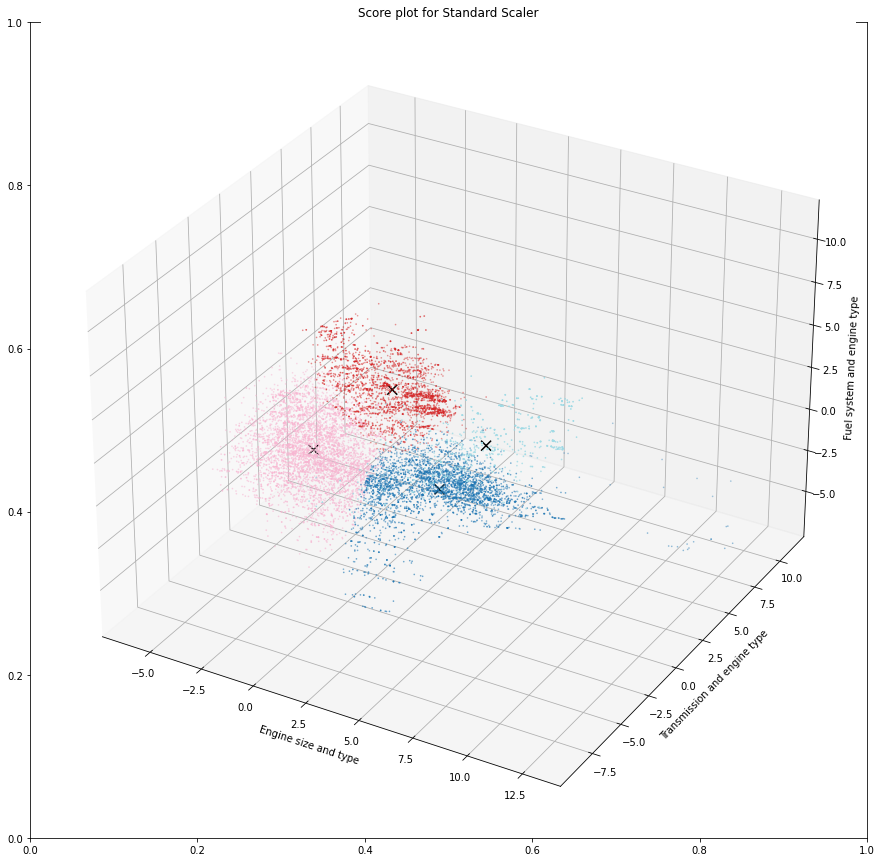

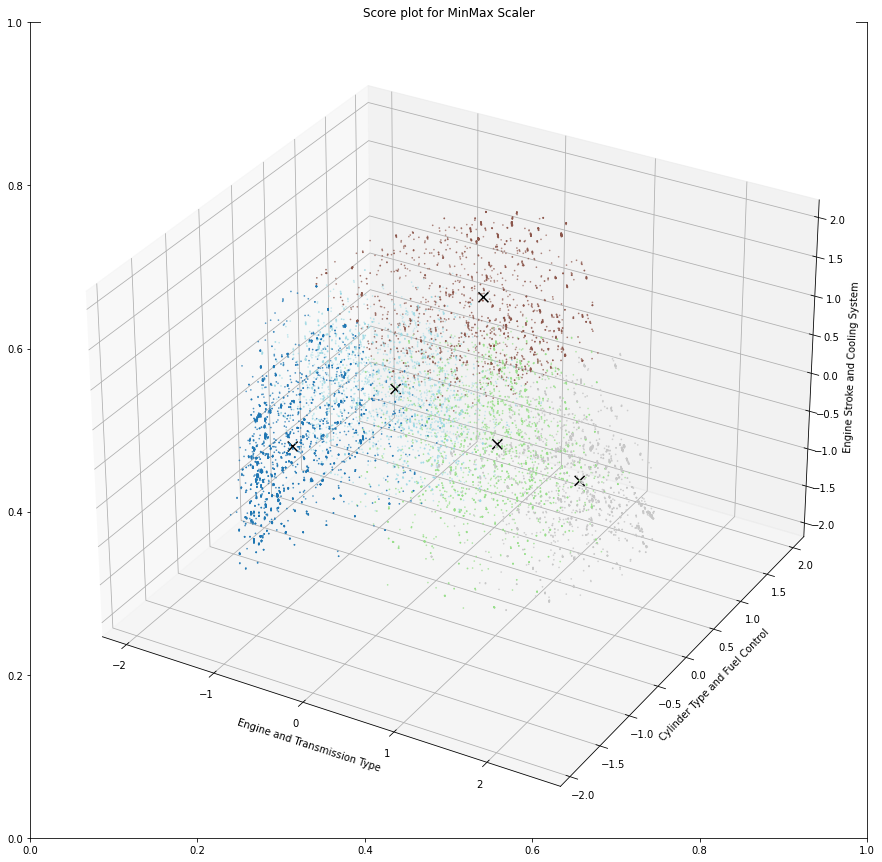

In [947]:
def plot_scores(Y, labels, centroids, num_pc, pc_names, title):
    
    # create the plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111)
    if num_pc == 2:
        ax.scatter(Y[:, 0], Y[:, 1], c=labels, cmap='tab20', s=0.5)
        ax.set_xlabel(f'{pc_names[0]}')
        ax.set_ylabel(f'{pc_names[1]}')
    else:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=labels, cmap='tab20', s=0.5)
        ax.set_xlabel(f'{pc_names[0]}')
        ax.set_ylabel(f'{pc_names[1]}')
        ax.set_zlabel(f'{pc_names[2]}')

    # add the centroids to the plot
    if num_pc == 2:
        ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
    else:
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], c='black', marker='x', s=100, alpha=1)
    
    # set the title
    ax.set_title(f'Score plot for {title}')
    
    plt.show()


# for Standard Scaler
plot_scores(Yworkdf_std,labels_std,centroids_std,num_pc_std,pc_std_names,"Standard Scaler")

# for MinMax Scaler
plot_scores(Yworkdf_mm,labels_mm,centroids_mm,num_pc_mm,pc_mm_names,"MinMax Scaler")

Exercise 7 - Optional (Clusters and Centroids Evaluation): 

In [948]:
from sklearn.metrics import silhouette_score

# Silhouette score for Standard Scaler
silhouette_std = silhouette_score(Yworkdf_std, labels_std)
print(f"Silhouette score for Standard Scaler: {silhouette_std}")

# Silhouette score for MinMax Scaler
silhouette_mm = silhouette_score(Yworkdf_mm, labels_mm)
print(f"Silhouette score for MinMax Scaler: {silhouette_mm}")


Silhouette score for Standard Scaler: 0.29366040342082145
Silhouette score for MinMax Scaler: 0.33202776466231027
